# Blade Element Momentum (BEM) Tutorial for Rotor Optimization

In this tutorial, we will use the blade element momentum (BEM) solver to optimize an arbitrary rotor geometry, specifically the rotor chord and twist.
We will minmize the rotor torque subject to a thrust constraint. The design variables will be blade chord and twist parameters (B-spline control points). For this tutorial, the flow will be axial, i.e., the free stream velocity is perpendicular to the rotor disk.

As always we fist import all sub-modules and start the `CSDL` recorder.

In [1]:
import csdl_alpha as csdl
from BladeAD.utils.var_groups import RotorAnalysisInputs, RotorMeshParameters
from BladeAD.utils.parameterization import BsplineParameterization
from BladeAD.core.airfoil.zero_d_airfoil_model import ZeroDAirfoilModel, ZeroDAirfoilPolarParameters
from BladeAD.core.BEM.bem_model import BEMModel
import numpy as np
import matplotlib.pyplot as plt


# Start CSDL recorder
recorder = csdl.Recorder(inline=True)
recorder.start()

The discretization is the same as in the previous tutorial, except that `num_nodes` is only 1 (we're only considering one oprating point), and `num_azimuthal` is also only 1 since we will set up the problem with axial flow, i.e., the flow is axisymmetric. Therefore, the inflow (and rotor loading) will not vary azimuthally.

In [2]:
# Discretization
num_nodes = 1 
num_radial = 35
num_azimuthal = 1 

num_blades = 2

We use the same simple 1-D airfoil model as in the previous tutorial and omit the plot of the airfoil polar here.

In [3]:
# Simple 1D airfoil model
# Specify polar parameters
polar_parameters = ZeroDAirfoilPolarParameters(
    alpha_stall_minus=-10.,
    alpha_stall_plus=15.,
    Cl_stall_minus=-1.,
    Cl_stall_plus=1.5,
    Cd_stall_minus=0.02,
    Cd_stall_plus=0.06,
    Cl_0=0.5,
    Cd_0=0.008,
    Cl_alpha=5.1566,
)
# Create airfoil model
airfoil_model = ZeroDAirfoilModel(
    polar_parameters=polar_parameters,
)

We start by setting up the inputs in the same way as in th previous tutorial.  Since we consider axial flow, the `thrust_vector` is set up accordingly, meaning in the $[1, 0, 0]$ direction. The `thrust_origin` is unchanged.

In [4]:
# Set up rotor analysis inputs
# 1) thrust (unit) vector and origin (origin is the rotor hub location and only needed for computing moments)
thrust_vector=csdl.Variable(name="thrust_vector", value=np.array([1., 0., 0.])) # Thrust vector in the negative z-direction (up)
thrust_origin=csdl.Variable(name="thrust_origin", value=np.array([0. ,0., 0.]))


## Blade Parameterization
Unlike in the previous tutorial, we do not directly provide the blade chord and twist profile. This is because the goal of this tutorial is to optimize the blade geometry (i.e., chord and twist) and directly prescribing the dense chord and twist profile as optimization design variables introduces `num_radialx2` design variables. This can not only increase optimization time but also lead to non-smooth (i.e., jagged) chord and twist profiles.

To reduce the number of design variables, we **parameterize the blade chord and twist profile using B-splines**. B-splines are piece-wise polynomials that are frequently used in computer-aided design (CAD) to smoothly represent geometries. 
In this case, we use B-spline curves to represent the blade chord and twist profile. A B-spline curve is expressed in terms of a parametric coordinate $u$
that is typically normalized between (0, 1).

$$
b(u) = \sum_{i=0}^m B_{i}(u)c_{i}, 
$$
where $B_i$ is the i-th basis function and $c_i$ is the i-th *control point*. 
These *control points* are the design variables that the optimizer updates to find the optimal design. In this tutorial we use 5 control points each for the chord and twist profile. We initialze the twist and chord control points as `CSDL` variables with linearly varying distributions from root to top.
The `set_as_design_variable` method is used to register the control points as design variables. 

Next, we instantiate a `BsplineParameterization` object, and pass in 
1. `num_radial`: the number of radial stations (blade elements). This specifies the size of the dense distribution of points.
2. `num_cp`: the number of control points
3. `order`: the order of the B-spline (degree + 1)

We evaluate the dense distributions (i.e., `chord_profile` and `twist_profile`) by calling the `evaluate` method and passing in the control points. 
Lastly, we visualize the inital chord and twist profiles, including the net of control points. 

<Figure size 640x480 with 0 Axes>

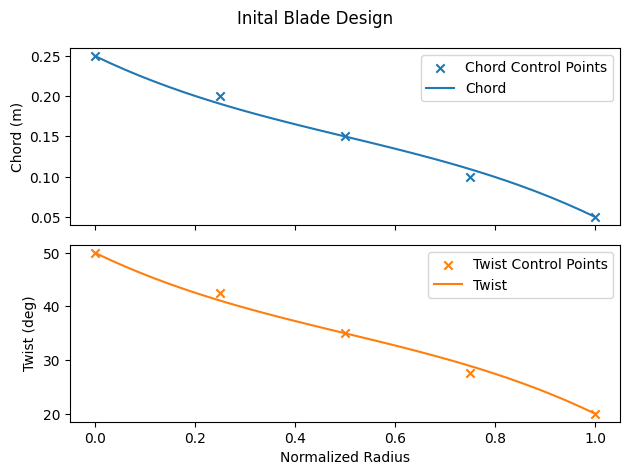

In [5]:
# 2) Rotor geometry 
# Chord and twist profiles parameterized as B-splines
# B-spline control points (design variables)
num_cp = 5
chord_profile_cps = csdl.Variable(name="chord_profile_cps", value=np.linspace(0.25, 0.05, num_cp)) # in meters
twist_profile_cps = csdl.Variable(name="twist_profile_cps", value=np.linspace(np.deg2rad(50), np.deg2rad(20), num_cp)) # Twist in RADIANS
# set control points as design variables
chord_profile_cps.set_as_design_variable(lower=0.01, upper=0.35, scaler=5)
twist_profile_cps.set_as_design_variable(lower=np.deg2rad(5), upper=np.deg2rad(85), scaler=2)

# Create B-spline parameterization
profile_parameterization = BsplineParameterization(
    num_radial=num_radial,
    num_cp=num_cp,
    order=4, # Cubic B-spline
)
# Evaluate radial profiles
chord_profile = profile_parameterization.evaluate_radial_profile(chord_profile_cps)
twist_profile = profile_parameterization.evaluate_radial_profile(twist_profile_cps)

# Visualize the chord and twist profiles
norm_rad = np.linspace(0, 1, num_radial)
plt.figure(1)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot chord profile
ax1.set_ylabel('Chord (m)')
ax1.scatter(np.linspace(0, 1, num_cp), chord_profile_cps.value, color='tab:blue', marker='x', label='Chord Control Points')
ax1.plot(norm_rad, chord_profile.value, label='Chord')
ax1.legend()

# Plot twist profile
ax2.set_xlabel('Normalized Radius')
ax2.set_ylabel('Twist (deg)')
ax2.scatter(np.linspace(0, 1, num_cp), np.rad2deg(twist_profile_cps.value), color='tab:orange', marker='x', label='Twist Control Points')
ax2.plot(norm_rad, np.rad2deg(twist_profile.value), label='Twist', color='tab:orange')
ax2.legend()
fig.suptitle('Inital Blade Design')



fig.tight_layout()

The rest of the inputs is simlar to the previous tutorial. The radius is set to 1.2 m. We set the mesh velocity only in the $u$ direction (i.e., axial flight) and set the RPM to 1500. 
The last step is to assemble the mesh parameters and rotor analysis inputs.


In [6]:
# Radius of the rotor
radius = csdl.Variable(name="radius", value=1.2)


# 3) Mesh velocity: vector of shape (num_nodes, 3) where each row is the 
# free streamvelocity vector (u, v, w) at the rotor center
mesh_vel_np = np.zeros((num_nodes, 3))
mesh_vel_np[:, 0] = 50 # Free stream velocity in the x-direction
mesh_velocity = csdl.Variable(value=mesh_vel_np)
# Rotor speed in RPM
rpm = csdl.Variable(value=1500 * np.ones((num_nodes,)))

# 4) Assemble inputs
# mesh parameters
bem_mesh_parameters = RotorMeshParameters(
    thrust_vector=thrust_vector,
    thrust_origin=thrust_origin,
    chord_profile=chord_profile,
    twist_profile=twist_profile, 
    radius=radius,
    num_radial=num_radial,
    num_azimuthal=num_azimuthal,
    num_blades=num_blades,
    norm_hub_radius=0.2,
)
# rotor analysis inputs
inputs = RotorAnalysisInputs(
    rpm=rpm,
    mesh_parameters=bem_mesh_parameters,
    mesh_velocity=mesh_velocity,
)

## Setting Optimization Objective and Constraint

After evaluating the BEM model, we access the outputs data class to set the objective and constraint. In this tutorial, we will minimiz the aerodynamic torque subject to a thrust constraint. We do so by using the following methods
- `set_as_objective()`
- `set_as_constraint()`

In essence, we are looking for most aerodynamically efficient design. It is tempting to choose aerodynamic efficiency as the objective (and maximize it). **However, this is a bad idea because the optimizer will likely find an unphysical design with an efficiency of greater than 1!** In addition, **scaling is very important in design optimization**. From the forward run, the baseline design outputs about 2200 N of thrust and the torque is about 850 N-m. We scale the thrust and torque accordingly. 

In [7]:
# Instantiate and run BEM model
bem_model = BEMModel(
    num_nodes=num_nodes,
    airfoil_model=airfoil_model,
    integration_scheme='trapezoidal',
)
bem_outputs = bem_model.evaluate(inputs=inputs)

# Set objective (minimize torque) and constraints (thrust)
torque = bem_outputs.total_torque
torque.set_as_objective(scaler=5e-3)

thrust = bem_outputs.total_thrust
thrust.set_as_constraint(equals=2000, scaler=1e-3)

# Print scalar outputs
print("Scalar Outputs before optimization:")
print(f"Total thrust: {bem_outputs.total_thrust.value}")
print(f"Total torque: {bem_outputs.total_torque.value}")
print(f"Efficiency: {bem_outputs.efficiency.value}")
print(f"Thrust coefficient: {bem_outputs.thrust_coefficient.value}")
print(f"Torque coefficient: {bem_outputs.torque_coefficient.value}")
print("\n")

nonlinear solver: bracketed_search converged in 41 iterations.
Scalar Outputs before optimization:
Total thrust: [2192.79165298]
Total torque: [848.33655833]
Efficiency: [0.82277164]
Thrust coefficient: [0.08631204]
Torque coefficient: [0.01391333]




/Users/mariusruh/Desktop/packages/lsdo/CSDL_alpha/csdl_alpha/src/operations/tensor/expand.py:184: UserWarning: "action" will have no effect when expanding a scalar.
  warnings.warn('"action" will have no effect when expanding a scalar.')
/Users/mariusruh/Desktop/packages/lsdo/CSDL_alpha/csdl_alpha/src/operations/division.py:19: RuntimeWarning: divide by zero encountered in divide
  return x/y


## Solving the optimization problem

To solve the optimization problem, we first instantiate a `CSDL` `PySimulator` object in import the [`modopt` library](https://modopt.readthedocs.io/en/latest/src/getting_started.html). 
We instantiate a `CSDLAlphaProblem` object as well as an optimizer (`SLSQP`) object, to which we pass the problem as well as options for the optimizer. Calling `optimizer.solve()` will run the optimization problem and  `optimizer.print_results()` will give information about the optimal solution (if it was obtained).

In [8]:
# set up optimization 
# csdl simulator
sim = csdl.experimental.PySimulator(
    recorder=recorder,
)

# Import modopt (if installed)
try:
    import modopt
except ImportError:
    raise ImportError("Please install modopt to run this example (see https://modopt.readthedocs.io/en/latest/src/getting_started.html)")

from modopt import CSDLAlphaProblem

# Setup your optimization problem
prob = CSDLAlphaProblem(problem_name='blade_optimization', simulator=sim)

# Setup your preferred optimizer (here, SLSQP) with the Problem object 
# Pass in the options for your chosen optimizer
optimizer = modopt.SLSQP(prob, solver_options={'maxiter': 200, 'ftol': 1e-5})

# Solve your optimization problem
optimizer.solve()
optimizer.print_results()

# Print scalar outputs
print("Scalar Outputs after optimization:")
print(f"Thrust coefficient: {bem_outputs.thrust_coefficient.value}")
print(f"Torque coefficient: {bem_outputs.torque_coefficient.value}")
print(f"Total thrust: {bem_outputs.total_thrust.value}")
print(f"Total torque: {bem_outputs.total_torque.value}")
print(f"Efficiency: {bem_outputs.efficiency.value}")
print("\n")


/Users/mariusruh/Desktop/packages/lsdo/CSDL_alpha/csdl_alpha/src/operations/division.py:19: RuntimeWarning: divide by zero encountered in divide
  return x/y


nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iterations.
nonlinear solver: bracketed_search converged in 41 iter

Lastly, we plot the optimized blade design.

<Figure size 640x480 with 0 Axes>

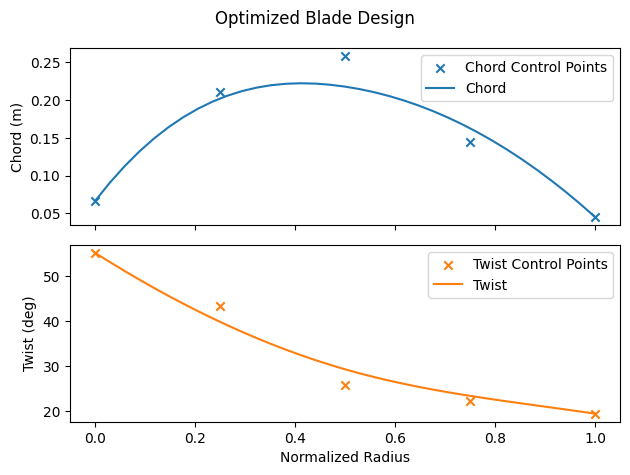

In [9]:
# Visualize the optimized chord and twist profiles
%matplotlib inline
plt.figure(2)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot chord profile
ax1.set_ylabel('Chord (m)')
ax1.scatter(np.linspace(0, 1, num_cp), chord_profile_cps.value, color='tab:blue', marker='x', label='Chord Control Points')
ax1.plot(norm_rad, chord_profile.value, label='Chord')
ax1.legend()

# Plot twist profile
ax2.set_xlabel('Normalized Radius')
ax2.set_ylabel('Twist (deg)')
ax2.scatter(np.linspace(0, 1, num_cp), np.rad2deg(twist_profile_cps.value), color='tab:orange', marker='x', label='Twist Control Points')
ax2.plot(norm_rad, np.rad2deg(twist_profile.value), label='Twist', color='tab:orange')
ax2.legend()
fig.suptitle('Optimized Blade Design')


fig.tight_layout()
plt.show()